# Differentiable Physics VI: Compressible Navier Stokes


We limit the scope of the solver with the following constraints:

- We use the conservative form of the equations, meaning we are looking at a volume which is fixed in space and the fluid is moving through it.
- We use a 2D grid based approach, where each cell in the grid represents a volume element and has size $\Delta x \times \Delta y$.

The following variables are used:

- $\vec{v_{i,j}}$ : velocity with x / y components $u$ and $v$
- $\rho$ : density
- $p$ : pressure
- $E$ : Total energy
- $e$ : internal energy
- $T$ : Temperature
- $\mu$ : viscosity constant
- $k$ : thermal conductivity constant
- $\Delta t$ : time step size
- $\Delta x$ : grid cell size in x direction
- $\Delta y$ : grid cell size in y direction

We can formulate the navier stokes equations for compressible flow as follows:

$$\frac{U}{\Delta t} + \frac{E}{\Delta x} + \frac{F}{\Delta y} = 0$$

where the state vector $U$ and the two fluxes $E$ and $F$ are defined as:

$$
U = \begin{bmatrix} \rho \\ \rho u \\ \rho v \\ E \end{bmatrix} \quad
E = \begin{bmatrix} \rho u \\ \rho u^2 + p - \tau_{xx} \\ \rho u v - \tau_{xy} \\ (E + p) u - u \tau_{xx} - v \tau_{xy} + q_x \end{bmatrix} 
F = \begin{bmatrix} \rho v \\ \rho u v - \tau_{xy} \\ \rho v^2 + p - \tau_{yy} \\ (E + p) v - u \tau_{xy} - v \tau_{yy} + q_y \end{bmatrix} $$

$\tau_{xx}$, $\tau_{xy}$, $\tau_{yy}$ are the components of the viscous stress tensor:

$$ \tau_{xx} = \mu \left( 2 \frac{\partial u}{\partial x} - \frac{2}{3} \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) \right) \quad
\tau_{xy} = \mu \left( \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \right) \quad
\tau_{yy} = \mu \left( 2 \frac{\partial v}{\partial y} - \frac{2}{3} \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) \right) $$

and $q_x$, $q_y$ are components of the heat flux vector.

$$ q_x = - \lambda \frac{\partial T}{\partial x} \quad
q_y = - \lambda \frac{\partial T}{\partial y} $$

Finally the following realtions hold:

$$ p = (\gamma - 1) \rho e \quad 
T = \frac{(\gamma - 1)e}{R}$$

where $R$ is the gas constant and $\gamma$ is the ratio of specific heats. For air we have $R = 287 m^2/(s^2 K)$ and $\gamma$ = 1.4. 


We now insert the navier stokes equations into the mac cormack method. We start with the predictor step:

$$\bar{U}_{i,j}^{n+1} = U_{i,j}^n - \frac{\Delta t}{\Delta x} \left( E_{i+1, j}^{n} - E_{i, j}^{n} \right) - \frac{\Delta t}{\Delta y} \left( F_{i, j+1}^{n} - F_{i, j}^{n} \right)$$

and the corrector step:

$$U_{i,j}^{n+1} = \frac{1}{2} \left[ \left( U_{i,j}^n + \bar{U}_{i,j}^{n+1} \right) - \frac{\Delta t}{ \Delta x} \left( \bar{E}_{i, j}^{n+1} - \bar{E}_{i-1, j}^{n+1} \right) - \frac{\Delta t}{\Delta y} \left( \bar{F}_{i, j}^{n+1} - \bar{F}_{i, j-1}^{n+1} \right) \right]$$

In [15]:
import jax.numpy as jnp
from jax import value_and_grad, jit, pure_callback
from functools import partial

@partial(jit, static_argnums=range(1, 3))
def fd(f : jnp.ndarray, delta : float, axis : int):
    return jnp.roll(f, -1, axis=axis) - f / delta

@partial(jit, static_argnums=range(1, 3))
def bd(f : jnp.ndarray, delta : float, axis : int):
    return f - jnp.roll(f, 1, axis=axis) / delta

@partial(jit, static_argnums=range(1, 3))
def cd(f : jnp.ndarray, delta : float, axis : int):
    return (jnp.roll(f, -1, axis=axis) - jnp.roll(f, 1, axis=axis)) / (2*delta)

In [16]:
@partial(jit, static_argnums=range(1, 3))
def unpack_state(
    state : jnp.ndarray, 
    gamma : float, # ratio of specific heats
    R : float # gas constant
):
    rho = state[:, :, 0]
    u = state[:, :, 1] / rho
    v = state[:, :, 2] / rho
    e = state[:, :, 3] / rho - 0.5 * (u**2 + v**2)
    dye = state[:, :, 4]
    T = (gamma - 1)*e / R # temperature
    p = (gamma - 1)*rho*e  # pressure

    return rho, u, v, T, p, dye

In [17]:
from jax.tree_util import Partial
@partial(jit, static_argnums=(range(2, 7)))
def get_stress(
    u : jnp.ndarray,
    v : jnp.ndarray,
    x_fwd : bool,
    y_fwd : bool,
    dx : float,
    dy : float,
    mu : float,
):
    d_dx = Partial(fd, delta=dx, axis=0) if x_fwd else Partial(bd, delta=dx, axis=0)
    d_dy = Partial(fd, delta=dy, axis=1) if y_fwd else Partial(bd, delta=dy, axis=1)

    tau_xx = 2/3*mu*(d_dx(u) - d_dy(v))
    tau_yy = 2/3*mu*(d_dy(v) - d_dx(u))
    tau_xy = mu*(d_dy(u) + d_dx(v))

    return tau_xx, tau_yy, tau_xy

In [18]:
@partial(jit, static_argnums=(range(1, 6)))
def get_heat_flux(
    T : jnp.ndarray,
    x_fwd : bool,
    y_fwd : bool,
    dx : float,
    dy : float,
    k : float,
):
    d_dx = Partial(fd, delta=dx, axis=0) if x_fwd else Partial(bd, delta=dx, axis=0)
    d_dy = Partial(fd, delta=dy, axis=1) if y_fwd else Partial(bd, delta=dy, axis=1)

    # heat flux
    q_x = -k*d_dx(T)
    q_y = -k*d_dy(T)

    return q_x, q_y

In [19]:
# U : [rho, rho*u, rho*v, E_total, dye]
@partial(jit, static_argnums=range(1, 7))
def get_EF(
    U : jnp.ndarray, # state vector
    x_fwd : bool,
    y_fwd : bool,
    dx : float,
    dy : float,
    mu : float, # viscosity
    gamma : float, #
    R : float, # gas constant
    k : float, # thermal conductivity
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """"
    Solver step for the compressible Stokes equations in 2D using the finite difference method along with the Mac Cormack method.
    """
    d_dx = Partial(fd, delta=dx, axis=0) if x_fwd else Partial(bd, delta=dx, axis=0)
    d_dy = Partial(fd, delta=dy, axis=1) if y_fwd else Partial(bd, delta=dy, axis=1)

    # unpack state vector
    rho, u, v, T, p, dye = unpack_state(U, gamma, R)
    E_total = U[:, :, 3]
    
    # viscous stress tensors
    tau_xx, tau_yy, tau_xy = \
        get_stress(u, v, x_fwd, y_fwd, dx, dy, mu)

    # heat flux
    q_x, q_y = \
        get_heat_flux(T, x_fwd, y_fwd, dx, dy, k)

    E = jnp.zeros_like(U)
    F = jnp.zeros_like(U)

    E = E.at[:,:,0].set(rho * u) # continuity equation
    E = E.at[:,:,1].set(rho * u ** 2 + p - tau_xx) # momentum equation
    E = E.at[:,:,2].set(rho * u * v - tau_xy) # momentum equation
    E = E.at[:,:,3].set((E_total + p) * u - u * tau_xx - v * tau_xy + q_x) # energy equation
    E = E.at[:,:,4].set(dye * u) # dye equation

    F = F.at[:,:,0].set(rho * v) # continuity equation
    F = F.at[:,:,1].set(rho * u * v - tau_xy) # momentum equation
    F = F.at[:,:,2].set(rho * v ** 2 + p - tau_yy) # momentum equation
    F = F.at[:,:,3].set((E_total + p) * v - u * tau_xy - v * tau_yy + q_y) # energy equation
    F = F.at[:,:,4].set(dye * v) # dye equation

    return E, F

In [20]:
@partial(jit, static_argnums=range(1, 6))
def compute_dt(
    state : jnp.ndarray,
    gamma : float,
    mu : float,
    sigma : float, # safety factor
    dx : float,
    dy : float,
):
    """
    Computes the largest time step that satisfies the CFL condition.
    """
    rho, u, v, T, p, dye = unpack_state(state, gamma, mu)
    
    a = jnp.sqrt(gamma * p / rho) # speed of sound

    Re_x = rho * jnp.abs(u) * dx / mu
    Re_y = rho * jnp.abs(v) * dy / mu

    Re = jnp.minimum(Re_x, Re_y)

    dt_CFL = (jnp.abs(u) / dx + jnp.abs(v) / dy + \
            a * jnp.sqrt( 1 / (dx ** 2) +  1 / (dy ** 2))) ** (-1)
    
    dt_grid = sigma * dt_CFL / ( 1 + 2 / Re)

    print("dt_CFL: ", dt_CFL)
    print("dt_grid: ", dt_grid)
    print("Re: ", Re)
    print("Re_x: ", Re_x)
    print("Re_y: ", Re_y)
    print("u: ", u)

    return jnp.min(dt_grid)

In [29]:
@partial(jit, static_argnums=range(1, 10))
def mac_cormack_2d(
    state : jnp.ndarray, # state vector
    x_fwd : bool,
    y_fwd : bool,
    dx : float,
    dy : float,
    mu : float, # viscosity
    gamma : float, # ratio of specific heats
    sigma : float, # safety factor
    R : float, # gas constant
    k : float, # thermal conductivity
) -> jnp.ndarray:
    d_dx_pred = Partial(fd, delta=dx, axis=0) if x_fwd else Partial(bd, delta=dx, axis=0)
    d_dy_pred = Partial(fd, delta=dy, axis=1) if y_fwd else Partial(bd, delta=dy, axis=1)

    d_dx_corr = Partial(fd, delta=dx, axis=0) if not x_fwd else Partial(bd, delta=dx, axis=0)
    d_dy_corr = Partial(fd, delta=dy, axis=1) if not y_fwd else Partial(bd, delta=dy, axis=1)

    dt = 0.3
    
    E, F = \
        get_EF(state, x_fwd, y_fwd, dx, dy, mu, gamma, R, k)

    U_pred = state - dt * (d_dx_pred(E) + d_dy_pred(F))
    
    E_pred, F_pred = \
        get_EF(U_pred, x_fwd, y_fwd, dx, dy, mu, gamma, R, k)

    state_fwd = 0.5 * ((state + U_pred) - dt * (d_dx_corr(E_pred) + d_dy_corr(F_pred)))

    return state_fwd

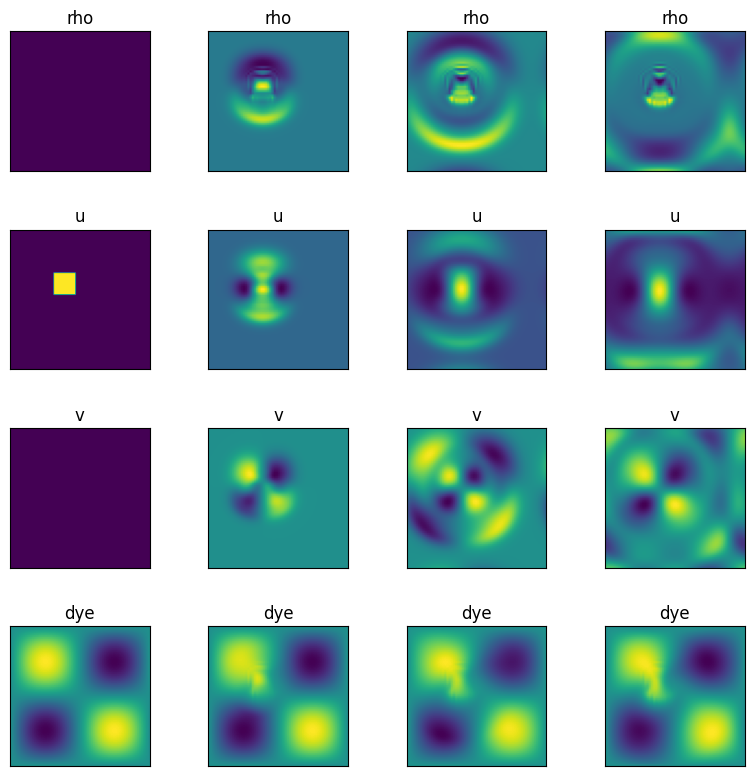

In [30]:
from jax import random
import matplotlib.pyplot as plt

from jax.config import config
#config.update('jax_disable_jit', False)

nx = 64
ny = 64

rho = jnp.ones((nx, ny), dtype=jnp.float32)
u = jnp.zeros((nx, ny), dtype=jnp.float32)
v = jnp.zeros((nx, ny), dtype=jnp.float32)
E_total = jnp.ones((nx, ny), dtype=jnp.float32)
dye = jnp.zeros((nx, ny), dtype=jnp.float32)
# 2d sine waves for initial conditions
x = jnp.linspace(0, 2*jnp.pi, nx)
y = jnp.linspace(0, 2*jnp.pi, ny)
X, Y = jnp.meshgrid(x, y)
dye = jnp.sin(X) * jnp.sin(Y)

u = u.at[20:30,20:30].set(0.5)

U = jnp.stack([rho, rho*u, rho*v, E_total, dye], axis=2)

dt = 0.01
dx = 1.0
dy = 1.0
mu = 0.3 # viscosity
gamma = 1.4 # ratio of specific heats
R = 200 # gas constant
k = 1.0 # thermal conductivity

n_views = 4
fig, axs = plt.subplots(4, n_views, figsize=(n_views*2, 8))
fig.tight_layout(pad=0.5)
iteration = 0

for i in range(4):
    rho, u, v, T, p, dye = unpack_state(U, gamma, R)
    axs[0, i].imshow(rho)
    axs[1, i].imshow(u)
    axs[2, i].imshow(v)
    axs[3, i].imshow(dye)

    axs[0, i].set_title(f"rho")
    axs[1, i].set_title(f"u")
    axs[2, i].set_title(f"v")
    axs[3, i].set_title(f"dye")

    # remove ticks
    for ax in axs[:, i]:
        ax.set_xticks([])
        ax.set_yticks([])

    for _ in range(50):
        iteration += 1
        odd = iteration % 2 == 1
        U = mac_cormack_2d(
            state = U,
            x_fwd=odd, y_fwd=odd,
            sigma=0.9, dx=dx, dy=dy,
            mu=mu, gamma=gamma, R=R, k=k
        )

In [31]:
def simulate(
    initial_state : jnp.ndarray,
    target_dye : jnp.ndarray,
    dt : float,
    dx : float,
    dy : float,
    mu : float, # viscosity
    gamma : float, # ratio of specific heats
    sigma : float, # safety factor
    R : float, # gas constant
    k : float, # thermal conductivity
    n_iter : int
):

    state = initial_state.copy()
    for i in range(n_iter):
        odd = i % 2 == 1
        state = mac_cormack_2d(
            state = state,
            x_fwd=odd, y_fwd=odd,
            sigma=sigma, dx=dx, dy=dy,
            mu=mu, gamma=gamma, R=R, k=k
        )

    rho, u, v, T, p, dye = unpack_state(state, gamma, R)

    return jnp.mean((dye - target_dye)**2)

loss_and_grad = value_and_grad(simulate, argnums=0)
        

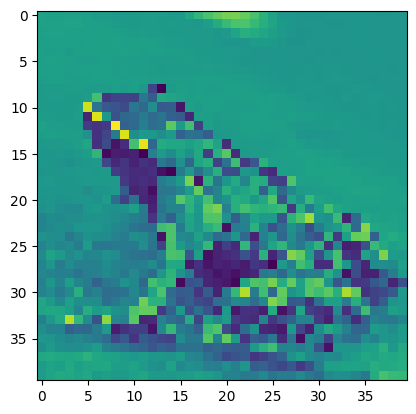

In [32]:
dye_target = jnp.array(plt.imread("img/frog.jpg"))
dye_target = dye_target[0:400 , 150:550, :]
dye_target = jnp.mean(dye_target, axis=-1)

# downsample to 40 x 40
dye_target = dye_target[::10, ::10]
nx = dye_target.shape[0]
ny = dye_target.shape[1]

plt.imshow(dye_target)


In [41]:
dt = 0.01
dx = 1.0
dy = 1.0
mu = 0.3 # viscosity
gamma = 1.4 # ratio of specific heats
R = 200 # gas constant
k = 1.0 # thermal conductivity

rho = jnp.ones((nx, ny), dtype=jnp.float32)
u = jnp.zeros((nx, ny), dtype=jnp.float32)
v = jnp.zeros((nx, ny), dtype=jnp.float32)
E_total = jnp.ones((nx, ny), dtype=jnp.float32)
dye = jnp.zeros((nx, ny), dtype=jnp.float32)
dye = dye.at[20:30,20:30].set(1.0)

state_cache = []

optimization_steps = 10
animation_steps = 200

learning_rate = 100

for i in range(optimization_steps):
    state = jnp.stack([rho, rho*u, rho*v, E_total, dye], axis=2)
    state_cache.append(state)

    loss, grad = loss_and_grad(
        state,
        target_dye = dye_target,
        dt = dt,
        dx = dx,
        dy = dy,
        mu = mu, # viscosity
        gamma = gamma, # ratio of specific heats
        sigma = 0.9, # safety factor
        R = R, # gas constant
        k = k, # thermal conductivity
        n_iter = animation_steps
    )

    rho = rho - learning_rate * grad[:, :, 0]
    u = u - learning_rate * grad[:, :, 1]
    v = v - learning_rate * grad[:, :, 2]
    E_total = E_total - learning_rate * grad[:, :, 3]

    print(f"loss: {loss}")


loss: 15448.373046875
loss: nan
loss: nan


Exception ignored in: <function _xla_gc_callback at 0x7f0c44760e50>
Traceback (most recent call last):
  File "/home/ar/miniconda3/envs/pbdl/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan
loss: nan


In [10]:
us = []

state = jnp.stack([rho, rho*u, rho*v, E_total, dye_cache[-1]], axis=2)

dye_animation = []
for i in range(animation_steps):
    state = mac_cormack_2d(
        state = state,
        x_fwd=True, y_fwd=True,
        sigma=0.9, dx=dx, dy=dy,
        mu=mu, gamma=gamma, R=R, k=k
    )
    

fig = plt.figure()

imp = plt.imshow(us[0], animated=True)
plt.close()

def updatefig(i):
    imp.set_array(us[i] * 10)
    return imp,

ani = animation.FuncAnimation(fig, updatefig, frames=range(animation_steps), interval=50, blit=True)
# video
# HTML(ani.to_jshtml())
# export to gif
ani.save("img/frog.gif", writer="imagemagick", fps=10)